In [1]:
## Exercise 6
# 1 Comment on your and other's solution to Exercise 5
# 2 Bias and variance of ridge regression (8 points)
# 3 Denoising of a CT image (11 points)

from matplotlib import colors
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import lsqr
import matplotlib.pyplot as plt


In [2]:
def construct_X(M, alphas, Np = None, tau=0):
    # M: input size, e.g. tissue size
    # Np: sensor maximum/desirable size
    # N: sensor desirable size * the numebr of rotation angle
    # X: output with shape [ N , D ]
    M = M + 1 if M % 2 == 0 else M
    Np = int(np.sqrt(2) * M) + 1 if Np == None else Np
    D = M * M 
    N = Np * len(alphas)
    # create an array C ∈ R[2×D] holding the coordinates of the tomogram's pixel centers
    c = (M - 1) / 2
    C1, C0 = np.mgrid[-c:c+1, -c:c+1]
    C1 = np.flip(C1)
    C = np.stack((C0,C1)).reshape(2,D)
    # the projection p of each pixel onto the sensor 
    # p = c0 * cos + c1 * sin
    # s0 is the distance between the first sensor element and the sensor's coordinate origin
    r = np.radians(alphas)
    n = np.stack((np.cos(r), np.sin(r))).reshape(2,len(r))
    s0 = (Np - 1) / 2 
    p = np.dot(n.T, C) + s0
    p_frac, p_int = np.modf(p)
    row = (p_int + Np * np.arange(len(alphas)).reshape(len(alphas),-1)).flatten()
    col = np.tile(np.arange(D),(len(alphas,)))
    weights = 1 - p_frac.flatten()
    row = np.append(row,row+1)
    col = np.append(col,col)
    weights = np.append(weights,1-weights)
    X = sparse.coo_matrix((weights, (row, col)), shape=(N, D), dtype = np.float32)
    if tau > 0: 
        Itau = sparse.coo_matrix(np.eye(D) * np.sqrt(tau))
        Xtau = sparse.vstack((X,Itau))
        return Xtau
    return X


In [4]:
# Reconstruct the tomogram for 64 angles with τ = 0,1,10,100,1000,10000

Y_195 = np.load("hs_tomography/y_195.npy")
beta_195 = np.load("hs_tomography/beta_195.npy")
alphas_195 = np.load("hs_tomography/alphas_195.npy")
ind = np.append(np.append(np.arange(3,89,3),np.arange(89,177)[::-3]),[0,1,2,177,178])
alphasS_195 = sorted(alphas_195[ind])
M = 195
Np = 275
YS_195 = np.zeros((len(ind) * Np + M*M))

for i in range(len(ind)):
    YS_195[Np * i : Np * (i+1)] = Y_195[Np * ind[i] : Np * (ind[i] + 1)] 

print("The number of reduced angles: ",len(alphasS_195))
print("The length of Y: ",len(YS_195))


The number of reduced angles:  64
The length of Y:  55625


Reconstruction Finished
Reconstruction Finished
Reconstruction Finished
Reconstruction Finished
Reconstruction Finished


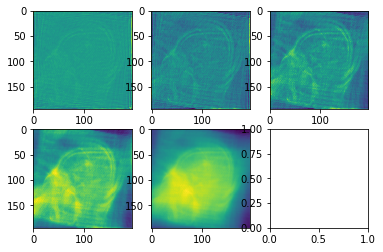

In [6]:
tauL = [1,10,100,1000,10000]
fig, ax = plt.subplots(2,3)
ax = ax.reshape(1,-1)

for t in range(len(tauL)): 
    XS_195 = construct_X(195, alphasS_195, Np, tau=tauL[t])
    print("Reconstruction Finished")
    betaS_195 = lsqr(XS_195, YS_195, atol = 1e-04, btol = 1e-04)
    imgS_195 = betaS_195[0].reshape(195,195)
    ax[0][t].imshow(imgS_195, interpolation = "none")

plt.show()


Gaussian filtering Finished
Gaussian filtering Finished
Gaussian filtering Finished
Gaussian filtering Finished
Gaussian filtering Finished


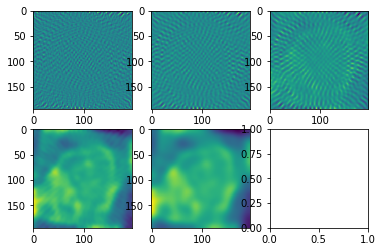

In [8]:
# Denoising with Gaussian filtering

from scipy.ndimage import gaussian_filter
Np = 275
YS_195 = np.zeros((len(ind) * Np))

for i in range(len(ind)):
    YS_195[Np * i : Np * (i+1)] = Y_195[Np * ind[i] : Np * (ind[i] + 1)] 

XS_195 = construct_X(195, alphasS_195, Np, tau=0)
betaS_195 = lsqr(XS_195, YS_195, atol = 1e-04, btol = 1e-04)
imgS_195 = betaS_195[0].reshape(195,195)
sigmaL = [1,2,3,5,7]
fig, ax = plt.subplots(2,3)
ax = ax.reshape(1,-1)

for s in range(len(sigmaL)): 
    imgG_195 = gaussian_filter(imgS_195, sigma=sigmaL[s])
    print("Gaussian filtering Finished")
    ax[0][s].imshow(imgG_195, interpolation = "none")

plt.show()



In [3]:
# 4 Automatic feature selection for regression
# 4.1 Implement Orthogonal Matching Pursuit (5 points)
# http://users.ece.utexas.edu/~sanghavi/courses/scribed_notes/Lecture_21_Scribe_Notes.pdf
# https://angms.science/doc/RM/OMP.pdf

def omp_regression(X, y, T):
    # X: X ∈ RN×D
    # y: y ∈ RN 
    # T > 0
    # beta^: D × T matrix, where D the initial number of features, T the number of iterations
    A = []
    B = np.arange(0, X.shape[1])
    r = y
    H = np.zeros((X.shape[1],))  
    while len(A) <= T:
        jt = np.argmax(np.dot(X[:,B].T, r))
        A.append(B[jt])
        B = B[B != B[jt]]
        beta = lsqr(X[:,A], y, atol = 1e-05, btol = 1e-05)[0]
        h = np.zeros((X.shape[1],))
        h[A,] = beta
        H = np.vstack((H,h))
        r = y - np.dot(X[:,A], beta)
    H = H[1:,:]
    return H.T



In [4]:
X = np.random.randint(0,20,200).reshape(20,10)
y = np.random.randint(0,100,20).reshape(20,)
T = 4
solutions = omp_regression(X, y, T)
print(solutions.shape)
solutions



(10, 5)


array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 3.83580703, 3.85288315, 3.67941471, 3.09603329],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 2.09079784, 1.93206391, 1.83014841],
       [0.        , 0.        , 0.        , 0.        , 0.9889447 ],
       [3.69891827, 1.46866388, 0.63887618, 0.36038327, 0.18991085],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.91565957, 0.64493095],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

In [23]:
# 4.2 Classi􏰃cation with sparse LDA (8 points)

from sklearn.datasets import load_digits
from sklearn import model_selection
digits = load_digits()
print(digits.keys())
data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]
X_sub = data[ (target== 1)|(target== 7) , : ]
Y_sub = target[ (target== 1)|(target== 7) ]
Y_sub[Y_sub==7] = -1
X_train , X_test , Y_train , Y_test = model_selection.train_test_split(X_sub, Y_sub, test_size = 0.4, random_state=0)


dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


In [26]:
def OMPclassifier(X_train, Y_train, X_test, Y_test, T):
    # X: X ∈ RN×D
    # y: y ∈ RN 
    # T > 0
    # beta^: D × T matrix, where D the initial number of features, T the number of iterations
    X = X_train
    y = Y_train
    A = []
    B = np.arange(0, X.shape[1])
    r = y
    H = np.zeros((X.shape[1],))  
    errO = []
    while len(A) < T:
        jt = np.argmax(np.abs(np.dot(X[:,B].T, r)))
        A.append(B[jt])
        B = B[B != B[jt]]
        beta = lsqr(X[:,A], y, atol = 1e-05, btol = 1e-05)[0]
        h = np.zeros((X.shape[1],))
        h[A,] = beta
        H = np.vstack((H,h))
        r = y - np.dot(X[:,A], beta)
        y_test = np.dot(X_test[:,A], beta)
        errO.append( np.sum(np.square((Y_test - y_test)), axis=0) )
    H = H[1:,:]
    return H.T, errO, A


(64, 64)
64
[106.64166745  30.71409131  19.98129849  16.59591119  18.09171816
  15.86508751  14.40448716  13.17321725  12.90803193  10.6937401
   9.36477515   9.88748772  10.13251293  10.17510875   9.74769041
   8.7569176    9.28287286   8.8398193    8.81116343   8.26998106
   8.28595909   8.50409043   8.37502466   8.51105947   9.10969534
   9.26630775   9.25387574   9.19042444   9.22004967   9.40829392
   9.35174546   9.40422707   9.34246415   9.39631136   9.20301569
   9.04126452   8.95116689   9.20142205   9.15004607   9.48435837
  13.10137829  13.22296611  13.18774497  13.26650155  13.33074784
  13.34594415  13.24797303  13.25305106  13.68279303  13.65179629
  13.66274216  13.66327256  14.11470632  14.11470632  14.11459134
  14.11459134  14.11457398  14.11457398  14.11444768  14.11444768
  14.11462439  14.11462439  14.11459134  14.11461025]


'\n\nsB = np.zeros((X_train.shape[1],T))\nfor i in range(len(A)):\n    sB[A[:i+1],i] = 1\n\nplt.figure()\nfig, ax = plt.subplots(1,2, figsize=(12,5))\nax = ax.reshape(1,-1)\nax[0][0].plot(np.arange(1,T+1),errO, label = "Mean square error", c=\'black\',alpha=0.8)\nax[0][1].imshow(sB,cmap=\'hot\',interpolation=\'nearest\',alpha=0.8)\nax[0][1].set(xticks=np.arange(1,T+1),yticks=np.arange(0,64))\nfig.tight_layout()\nplt.show\n'

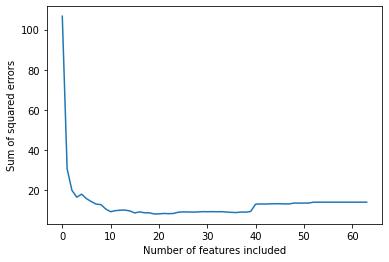

In [27]:
T = 64
solutions, errO, A  = OMPclassifier(X_train, Y_train, X_test, Y_test, T)
print(solutions.shape)
print(len(A))


M = 195
D = M*M
y_test = np.dot(X_test, solutions)
# compute the sum of squared error for each T (number of pixels included) and plot
sse = np.sum(np.square(y_test - Y_test.reshape(-1,1)), axis=0)
print(sse)
plt.plot(np.arange(len(sse)), sse)
plt.xlabel('Number of features included')
plt.ylabel('Sum of squared errors');

'''

sB = np.zeros((X_train.shape[1],T))
for i in range(len(A)):
    sB[A[:i+1],i] = 1

plt.figure()
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax = ax.reshape(1,-1)
ax[0][0].plot(np.arange(1,T+1),errO, label = "Mean square error", c='black',alpha=0.8)
ax[0][1].imshow(sB,cmap='hot',interpolation='nearest',alpha=0.8)
ax[0][1].set(xticks=np.arange(1,T+1),yticks=np.arange(0,64))
fig.tight_layout()
plt.show
'''

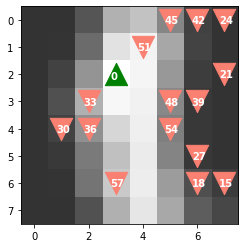

In [15]:
# Show the active pixel order

X_mean1 = np.mean(X_sub[Y_sub == 1], axis=0).reshape(8,8)
plt.figure()
plt.imshow(X_mean1,interpolation='nearest',alpha=0.8)
plt.gray()
Coo = np.arange(0,64).reshape(8,8)

for i in range(0,solutions.shape[1],3):
    y, x = np.where(Coo==A[i])
    if solutions[A[i],i] > 0:
        plt.annotate(str(i), xy=(x, y),xytext=(x-0.20, y+0.18), c="white", weight="bold")
        plt.scatter(x, y, s=500, c='green', marker="^")
    elif solutions[A[i],i] < 0:
        plt.annotate(str(i), xy=(x, y),xytext=(x-0.20, y+0.12), c="white", weight="bold")
        plt.scatter(x, y, s=500, c='salmon', marker="v")

plt.show()



In [5]:
# 4.3 One-against-the-rest classi􏰃cation (8 points)

from sklearn.datasets import load_digits
from sklearn import model_selection
import pandas as pd
digits = load_digits()
data = digits["data"]
target = digits["target"]
X_train , X_test , Y_train , Y_test = model_selection.train_test_split(data, target,test_size = 0.4)



In [9]:
class OvR:
    def __init__(self):
        pass
    def fit(self, X_train, Y_train):
        beta = np.zeros((X_train.shape[1],))  
        for d in set(Y_train):
            print("Train OvRclassifier for ",str(d))
            X_one = X_train[Y_train == d]
            Y_one = np.array([1] * len(X_one))
            ind = np.random.choice(len(Y_train)-len(Y_one), len(Y_one))
            X_rest = X_train[Y_train != d][ind,:]
            Y_rest = np.array([-1] * len(X_rest))
            X_aux = np.vstack((X_one, X_rest))
            Y_aux = np.hstack((Y_one, Y_rest))
            solutions = omp_regression(X=X_aux, y=Y_aux, T=60)[:,-1]
            beta = np.vstack((beta,solutions))
        self.beta = beta[1:,:].T
        return self.beta
    def predict(self, X_test):
        y_test = np.dot(X_test, self.beta)
        un = np.all(y_test < 0, axis=1)
        y_test = np.argmax(y_test, axis=1)
        y_test[un] = 99
        return y_test
    def evalute(self, y_test, Y_test):
        df = pd.DataFrame({'True': Y_test, 'Predicted':y_test}) 
        cm = pd.crosstab(df['True'], df['Predicted'], rownames=['True'], colnames=['Predicted'])
        return cm



In [10]:
ovr = OvR()
ovr.fit(X_train, Y_train)
y_test = ovr.predict(X_test)
cm = ovr.evalute(y_test, Y_test)
print(cm)



Train OvRclassifier for  0
Train OvRclassifier for  1
Train OvRclassifier for  2
Train OvRclassifier for  3
Train OvRclassifier for  4
Train OvRclassifier for  5
Train OvRclassifier for  6
Train OvRclassifier for  7
Train OvRclassifier for  8
Train OvRclassifier for  9
Predicted  0   1   2   3   4   5   6   7   8   9   99
True                                                 
0          72   0   0   1   1   1   2   0   2   4   0
1           0  58   1   0   0   0   0   0   1   4   0
2           0   3  61   1   0   0   0   0   3   0   0
3           0   0   0  68   0   1   0   1   4   3   2
4           0   6   0   0  57   0   0   1   1   2   0
5           0   0   0   1   0  63   0   0   0   3   0
6           1   1   0   0   0   0  71   0   0   0   0
7           1   0   0   2   0   0   0  56   1   1   0
8           0   4   0   1   2   2   0   0  51  10   1
9           0   0   0   0   0   5   0   0   4  76   1
